# Encoding by pronouciation

## preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import re

In [319]:
import wn
from wn import morphy 
ewn = wn.Wordnet('ewn:2020')
m = morphy.Morphy(ewn)

In [27]:
pronouncing_dict_path = './cmudict.dict.txt'

In [168]:
dico = {}
with open(pronouncing_dict_path, 'r', encoding='utf-8') as file:
	for line in file.readlines():
		line = re.sub('\d', '', line) # remove tone number
		l = line.strip().split(' ')
		word = l[0]
		pronounciation = ' '.join(l[1:])
		# filter some non standard words
		if word.islower() and word.isalpha():
			dico[word] = pronounciation

In [264]:
len(dico)

52008

first check if the word exists in wordnet

In [171]:
def validate(word):
	# check if exists
	res = wn.synsets(word)
	if res != []:
		return True
	# otherwise check if as a derivation, the lemma exists
	for lemmas_per_pos in m(word).values():
		for lemma in lemmas_per_pos:
			res = wn.synsets(lemma)
			# if there exists one, return
			if res != []:
				return True
	return False

In [318]:
from tqdm import tqdm

In [65]:
non_words = []
for word in tqdm(dico.keys()):
	if not validate(word):
		non_words.append(word)

100%|██████████| 117490/117490 [01:01<00:00, 1897.98it/s]


In [66]:
len(non_words)

65445

In [ ]:
with open('./non_wordnet_words.txt', 'w', encoding='utf-8') as file:
	for non_word in non_words:
		file.write(non_word+'\n')

However, wordnet excludes some function words, they should be taken into account in dictionary

In [172]:
with open('./non_wordnet_words.txt', 'r', encoding='utf-8') as file:
	non_words = file.read().splitlines()

In [173]:
with open('./wordnet_stopwords.txt', 'r', encoding='utf-8') as file:
	stop_words = file.read().splitlines()

In [174]:
for non_word in non_words:
	if not non_word in stop_words:
		dico.pop(non_word)

In [175]:
len(dico)

52123

Notice that many of them are acronyms, which is pronounced as individual letters, we could remove them directly from the cmu dict, the acronyms will be dealed in another independent dico.

## Remove acronyms

first collect single letter sound

In [176]:
letter_sound = {}
syllable_count = {}
for word, sound in dico.items():
	if len(word) == 1:
		letter_sound[word] = list(sound.split(' '))
		syllable_count[word] = len(sound.split(' '))

In [177]:
letter_sound['a'] = ['EY'] # A sounds EY1 not AH0

In [178]:
letter_sound, syllable_count

({'a': ['EY'],
  'b': ['B', 'IY'],
  'c': ['S', 'IY'],
  'd': ['D', 'IY'],
  'e': ['IY'],
  'f': ['EH', 'F'],
  'g': ['JH', 'IY'],
  'h': ['EY', 'CH'],
  'i': ['AY'],
  'j': ['JH', 'EY'],
  'k': ['K', 'EY'],
  'l': ['EH', 'L'],
  'm': ['EH', 'M'],
  'n': ['EH', 'N'],
  'o': ['OW'],
  'p': ['P', 'IY'],
  'q': ['K', 'Y', 'UW'],
  'r': ['AA', 'R'],
  's': ['EH', 'S'],
  't': ['T', 'IY'],
  'u': ['Y', 'UW'],
  'v': ['V', 'IY'],
  'w': ['D', 'AH', 'B', 'AH', 'L', 'Y', 'UW'],
  'x': ['EH', 'K', 'S'],
  'y': ['W', 'AY'],
  'z': ['Z', 'IY']},
 {'a': 1,
  'b': 2,
  'c': 2,
  'd': 2,
  'e': 1,
  'f': 2,
  'g': 2,
  'h': 2,
  'i': 1,
  'j': 2,
  'k': 2,
  'l': 2,
  'm': 2,
  'n': 2,
  'o': 1,
  'p': 2,
  'q': 3,
  'r': 2,
  's': 2,
  't': 2,
  'u': 2,
  'v': 2,
  'w': 7,
  'x': 3,
  'y': 2,
  'z': 2})

In [193]:
def is_acronym(word, sound, threshold=2, show = False):
	matched = 0
	offset = 0
	sound_list = sound.split(' ')
	for letter in word:
		step = syllable_count[letter]
		if show:
			print(letter_sound[letter])
			print(sound_list[offset:offset+step])

		if letter_sound[letter] == sound_list[offset:offset+step]:
			matched += 1
		if matched >= threshold:
			return True
		offset += step
	return False

In [194]:
is_acronym('abc',dico['abc']), is_acronym('good', dico['good']), is_acronym('aardvark', dico['aardvark'], show=True)

['EY']
['AA']
['EY']
['R']
['AA', 'R']
['D', 'V']
['D', 'IY']
['AA', 'R']
['V', 'IY']
['K']
['EY']
[]
['AA', 'R']
[]
['K', 'EY']
[]


(True, False, False)

In [201]:
acronyms = []
for (word, sound) in dico.items():
	if len(word) > 4:
		continue
	if is_acronym(word, sound, 2):
		acronyms.append(word)

In [202]:
len(acronyms)

114

In [204]:
for word in acronyms:
	dico.pop(word)

In [213]:
dico.pop('aaa')

'T R IH P AH L EY'

In [270]:
len(dico)

52008

now we get a well pronounced, wordnet-validated dictionary

In [271]:
df = pd.DataFrame.from_dict(dico, orient='index', columns = ['sound'])

In [265]:
df_freq = pd.read_csv('./dict_freq_en.yaml', sep = '\t', index_col=0, usecols=[1,2])
df_freq

,COUNT
WORD,
the,4888
of,4883
and,4878
to,4873
in,4868
...,...
bepride,0
batterable,0
batsome,0


In [272]:
df = df.join(df_freq.astype('Int64'))

In [273]:
df.index.name = 'word'

In [274]:
df.rename(columns={'COUNT': 'freq'}, inplace=True)

In [275]:
df

,sound,freq
word,,
a,AH,4863
aachen,AA K AH N,<NA>
aalborg,AO L B AO R G,<NA>
aalto,AA L T OW,<NA>
aardvark,AA R D V AA R K,<NA>
...,...,...
zuni,Z UW N IY,<NA>
zurich,Z UH R IH K,<NA>
zweig,Z W AY G,<NA>


## Transcription

In [221]:
def encode(phonemes):
	vowels = re.compile('(AO|UW|EH|AH|AA|IY|IH|UH|AE|AW|AY|ER|EY|OW|OY)\d*', re.VERBOSE)
	phonemes = re.sub(vowels, 'Q', phonemes)
	complex_consonant = re.compile('CH|DH|HH|JH|NG|SH|TH|ZH|')
	# complex consonants
	phonemes = re.sub('HH', 'H', phonemes)
	phonemes = re.sub('CH', 'C', phonemes)
	phonemes = re.sub('JH', 'J', phonemes)
	phonemes = re.sub('TH', 'X', phonemes)
	phonemes = re.sub('DH', 'X', phonemes)
	phonemes = re.sub('SH', 'U', phonemes)
	phonemes = re.sub('ZH', 'O', phonemes)
	phonemes = re.sub('NG', 'I', phonemes)
	
	# remove whitespaces
	phonemes = re.sub(' ', '', phonemes)

	return phonemes

In [222]:
def transcribe(phonemes_list):
	encoding_list = []
	for phonemes in phonemes_list:
		encoding_list.append(encode(phonemes))
	return encoding_list

In [276]:
encoding_list = transcribe(df.sound.astype('str'))
df['encoding'] = encoding_list

In [277]:
df

,sound,freq,encoding
word,,,
a,AH,4863,Q
aachen,AA K AH N,<NA>,QKQN
aalborg,AO L B AO R G,<NA>,QLBQRG
aalto,AA L T OW,<NA>,QLTQ
aardvark,AA R D V AA R K,<NA>,QRDVQRK
...,...,...,...
zuni,Z UW N IY,<NA>,ZQNQ
zurich,Z UH R IH K,<NA>,ZQRQK
zweig,Z W AY G,<NA>,ZWQG


## delete non-initial vowels

In [225]:
def remove_vowels(encoding_list):
	res = []
	for encoding in encoding_list:
		if len(encoding) > 1:
			res.append(encoding[0] + re.sub('Q','', encoding[1:-1]) + encoding[-1])
		else:
			res.append(encoding)
	return res

## Normalization

We hope that:
1. the plurals and the third person single form are uniformly terminated with S(instead of Z)
2. the past particles are uniformly terminated with E(instead of T or D)
3. the present particles are uniformly terminated with I(this is already done since we encode NG sound by I)

you can take these terminations as a grammatical symbol

In [226]:
df.encoding.loc[(df.index.str.contains('s$', regex=True) == True)]

word
aardvarks           QRDVQRKS
aarhus                  QHQS
abacus                QBQKQS
abalones            QBQLQNQZ
abandonments    QBQNDQNMQNTS
                    ...     
zones                   ZQNZ
zoologists        ZQQLQJQSTS
zooms                   ZQMZ
zoos                     ZQZ
zucchinis            ZQKQNQZ
Name: encoding, Length: 13299, dtype: object

In [227]:
df.encoding.loc[(df.index.str.contains('ed$', regex=True) == True)]

word
abandoned        QBQNDQND
abashed             QBQUT
abated             QBQTQD
abbreviated    QBRQVQQTQD
abdicated       QBDQKQTQD
                  ...    
zigzagged         ZQGZQGD
zipped               ZQPT
zippered            ZQPQD
zoned                ZQND
zoomed               ZQMD
Name: encoding, Length: 4701, dtype: object

In [228]:
df.encoding.loc[(df.index.str.contains('ing$', regex=True) == True)]

word
abandoning       QBQNDQNQI
abating             QBQTQI
abbreviating    QBRQVQQTQI
abdicating       QBDQKQTQI
abducting         QBDQKTQI
                   ...    
zing                   ZQI
zippering          ZQPQRQI
zipping              ZQPQI
zoning               ZQNQI
zooming              ZQMQI
Name: encoding, Length: 4323, dtype: object

In [229]:
def normalize(encodings: pd.Series):
	plurals_or_third_single_form  = re.compile('s$')
	past_particle = re.compile('ed$')
	present_particle = re.compile('ing$')

	# print(encodings.head())
	# normalize voiced plural suffix
	res1 = encodings.loc[(encodings.index.str.contains(plurals_or_third_single_form, regex=True) == True)].str.replace('Z$', 'S', regex=True)
	# print(res1.head())
	# normalize -ed, sometimes together with a vowel sound i.
	res2 = encodings.loc[(encodings.index.str.contains(past_particle, regex=True) == True)].str.replace('[T|D]$', 'E', regex = True)
	# print(res2.head())
	# normalize -ing, always with a vowel sound i
	# we put it here for compeleteness, though no need to do
	# res3 = encodings.loc[(encodings.index.str.contains(present_particle, regex=True) == True)].str.replace('I$', 'I', regex = True)
	# print(res3.head())
	
	res = pd.concat([res1
									,res2
									# ,res3
									])
	return res

In [278]:
res = normalize(df.encoding)

In [279]:
df.loc[['depends','depended','depending'], 'encoding']

word
depends       DQPQNDZ
depended     DQPQNDQD
depending    DQPQNDQI
Name: encoding, dtype: object

In [280]:
df.loc[res.index, 'encoding'] = res

In [281]:
df.loc[['depends','depended','depending'], 'encoding']

word
depends       DQPQNDS
depended     DQPQNDQE
depending    DQPQNDQI
Name: encoding, dtype: object

## Detect inefficient encoding

In [282]:
df['vowel_free'] = remove_vowels(df.encoding) 

In [283]:
# with pd.option_context('display.max_rows', None):
acronym_residue = df.loc[(df.index.str.len() > 1) & (df.index.str.len() <= 4) & (df.index.str.len() < df.vowel_free.str.len()) & (~df.freq.notna()), ['sound','encoding','vowel_free','freq']]
display(acronym_residue)

,sound,encoding,vowel_free,freq
word,,,,
aug,AO G AH S T,QGQST,QGST,<NA>
ct,K AO R T,KQRT,KRT,<NA>
emu,IY M Y UW,QMYQ,QMYQ,<NA>
expo,EH K S P OW,QKSPQ,QKSPQ,<NA>
feb,F EH B Y AH W EH R IY,FQBYQWQRQ,FBYWRQ,<NA>
hz,HH ER T Z,HQTZ,HTZ,<NA>
jr,JH UW N Y ER,JQNYQ,JNYQ,<NA>
lb,P AW N D,PQND,PND,<NA>
lbs,P AW N D Z,PQNDS,PNDS,<NA>


In [284]:
df.drop(acronym_residue.index, inplace=True)

In [285]:
len(df)

51993

Notice that many of them are acronyms, which is pronounced as individual letters, we could remove them directly from the cmu dict, the acronyms will be dealed in another independent dico.

In [286]:
df.to_csv('./dict_en.csv')

In [287]:
df = pd.read_csv('./dict_en.csv', index_col=0, dtype={'sound':str,'freq':pd.Int64Dtype(),'encoding':str,'vowel_free':str}, na_filter=False)

In [288]:
df

,sound,freq,encoding,vowel_free
word,,,,
a,AH,4863,Q,Q
aachen,AA K AH N,<NA>,QKQN,QKN
aalborg,AO L B AO R G,<NA>,QLBQRG,QLBRG
aalto,AA L T OW,<NA>,QLTQ,QLTQ
aardvark,AA R D V AA R K,<NA>,QRDVQRK,QRDVRK
...,...,...,...,...
zuni,Z UW N IY,<NA>,ZQNQ,ZNQ
zurich,Z UH R IH K,<NA>,ZQRQK,ZRK
zweig,Z W AY G,<NA>,ZWQG,ZWG


In [289]:
df.loc['abbreviated']

sound         AH B R IY V IY EY T IH D
freq                                50
encoding                    QBRQVQQTQE
vowel_free                      QBRVTE
Name: abbreviated, dtype: object

## Encoding Statistics

encoding length

In [306]:
def plot_string_length_freq(encodings: pd.DataFrame):
	wd_length = encodings.reset_index().apply(lambda x: x.str.len(), axis=0).astype(pd.Int64Dtype())
	display(wd_length.describe(percentiles=[.9,.95,.99]).drop(['count','50%','min']))

	wd_length_count = wd_length.melt()
	wd_length_count = wd_length_count.pivot_table(index='value', columns='variable', values='value', aggfunc='size')
	plt.style.use('seaborn-v0_8-notebook')
	wd_length_count.plot(kind='bar')
	

- less average encoding length: lazier
- less standard deviation of encoding length: evener

,word,encoding,vowel_free
mean,7.930279,6.840308,4.642964
std,2.452292,2.36637,1.509648
90%,11.0,10.0,7.0
95%,12.0,11.0,7.0
99%,14.0,13.0,9.0
max,20.0,18.0,12.0


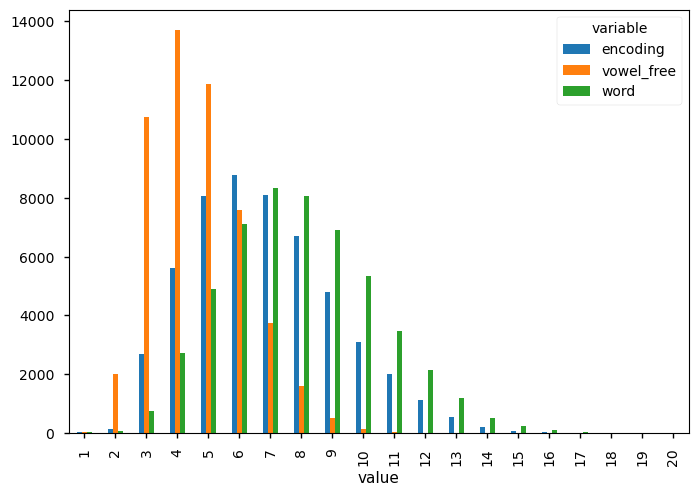

In [307]:
plot_string_length_freq(df[['encoding', 'vowel_free']])

coincident codes: counts of words with same encoding

In [308]:
def coincident_stats(encodings: pd.DataFrame, ext = 10):
	total = len(encodings)

	multiplicity = encodings.value_counts()
	multiplicity.index.name = 'encoding'
	multiplicity.name = 'multiplicity'

	multiplicity_freq = multiplicity.value_counts()
	multiplicity_freq.index.name = 'multiplicity'
	multiplicity_freq.name = 'freq'

	coincident_rate = 1 - (multiplicity_freq.loc[1]) / multiplicity_freq.sum()

	extremes = multiplicity_freq.loc[ext+1:]
	word_count_with_extreme_encodings = (extremes.index.to_numpy() * extremes.values).sum()
	ratio_with_extreme_encodings = np.round( word_count_with_extreme_encodings/total *100 , 2)

	print(f'coincident_rate: {np.round(coincident_rate * 100,2)}%')
	print(f'There are {extremes.sum()} encodings have more than {ext} multiplicities, encoding {word_count_with_extreme_encodings}({ratio_with_extreme_encodings}%) words.')

	q = multiplicity.quantile([.8,.9,.95,.99])
	q.index.name = 'quantile'
	q.name = 'multiplicity'

	print('extreme:')
	display(extremes.to_frame())
	print('quantile:')
	display(q.to_frame())

	extreme_encoding = pd.Series(multiplicity[multiplicity > ext].index)
	extreme_encoding.name = 'freq'
	extreme_encoding.index.name = 'encoding_length'
	if len(extreme_encoding) > 0:
		# display(extreme_encoding)
		sn.barplot(x = extreme_encoding.str.len().value_counts().index, y = extreme_encoding.str.len().value_counts())
	# plt.hist(multiplicity,bins=range(min(multiplicity), max(multiplicity)+1,1))
	return multiplicity, multiplicity_freq, extreme_encoding

no coincidence in original dictionary lexicon(of course)

In [309]:
_ = coincident_stats(df.index)

coincident_rate: 0.0%
There are 0 encodings have more than 10 multiplicities, encoding 0(0.0%) words.
extreme:


,freq
multiplicity,


quantile:


,multiplicity
quantile,
0.80,1.0
0.90,1.0
0.95,1.0
0.99,1.0


coincident_rate: 13.81%
There are 97 encodings have more than 10 multiplicities, encoding 1294(2.49%) words.
extreme:


,freq
multiplicity,
11,28
13,18
12,17
14,14
15,6
19,4
20,3
18,3
16,2


quantile:


,multiplicity
quantile,
0.80,1.0
0.90,2.0
0.95,3.0
0.99,6.0


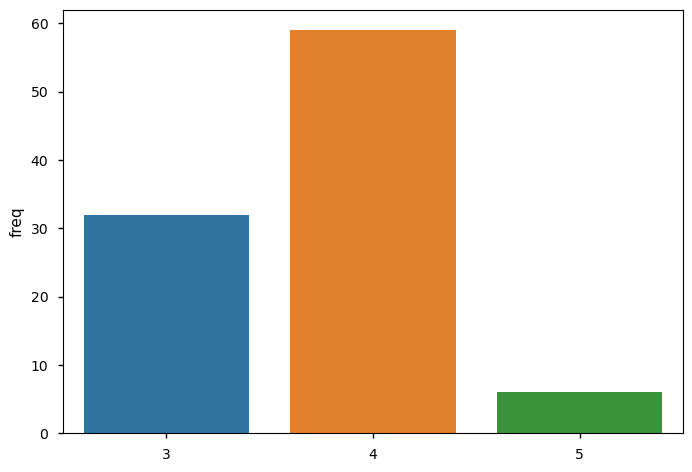

In [310]:
_ = coincident_stats(df.encoding)

coincident_rate: 18.47%
There are 240 encodings have more than 10 multiplicities, encoding 3658(7.04%) words.
extreme:


,freq
multiplicity,
11,48
12,41
14,31
13,26
15,19
16,14
19,11
17,10
21,7


quantile:


,multiplicity
quantile,
0.80,1.0
0.90,2.0
0.95,3.0
0.99,9.0


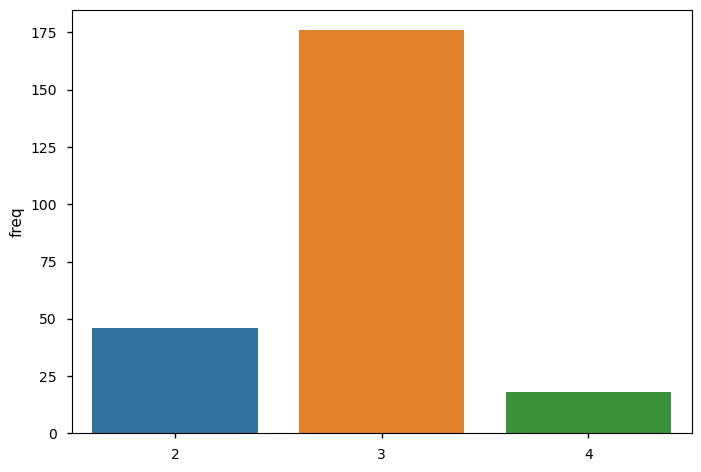

In [311]:
multiplicity, _, extreme_encoding = coincident_stats(df.vowel_free)

let's taker a careful look at the extreme encodings

In [312]:
extreme_encoding

encoding_length
0      BLS
1      FLS
2      KLS
3      FLQ
4      PLS
      ... 
235     KK
236     MN
237    NTS
238    BNT
239     BQ
Name: freq, Length: 240, dtype: object

In [313]:
multiplicity[multiplicity > 10]

encoding
BLS    39
FLS    38
KLS    35
FLQ    35
PLS    34
       ..
KK     11
MN     11
NTS    11
BNT    11
BQ     11
Name: multiplicity, Length: 240, dtype: int64

In [367]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
	display(multiplicity[multiplicity > 10])
	display(df[df.vowel_free.isin(['BLS','FLS'])])

encoding
BLS     36
FLS     31
KLS     31
PLS     26
BRS     24
SLS     23
KRS     22
PRS     20
WLS     20
GLS     20
HLS     19
DNS     19
KLQ     19
BTS     19
MTS     19
FLQ     19
MNS     19
BKS     19
LKS     18
BLQ     17
TNQ     17
TRS     17
SRS     17
FLTS    16
PLTS    16
HRS     16
MLQ     16
SKTS    16
FRS     16
HLQ     15
BLE     15
LNS     15
BRN     15
KKS     15
TNS     15
MRS     15
RKS     15
STS     15
SLQ     14
RLS     14
PLT     14
PPS     14
WLQ     14
BRQ     14
QLS     14
TLS     14
BNS     14
PSS     13
FLI     13
RDS     13
MLS     13
RMS     13
DKS     13
HKS     13
SPS     13
TMS     13
MNQ     13
STRS    13
STE     13
TKS     13
GRS     13
BRKS    12
STKS    12
DKQ     12
SPRS    12
TRTS    12
LTS     12
STL     12
PKS     12
STN     12
RTS     12
SLTS    12
UTS     12
DMS     12
RDQ     12
KRNS    12
DLS     12
FLE     12
PLQ     12
KLI     12
HMS     11
BRK     11
KLN     11
SKQ     11
SKL     11
WKS     11
MTQ     11
SNS     11
KRNQ    11
PLE     11
K

,sound,freq,encoding,vowel_free
word,,,,
bailes,B EY1 L Z,<NA>,BQLS,BLS
baileys,B EY1 L IY0 Z,<NA>,BQLQS,BLS
bails,B EY1 L Z,<NA>,BQLS,BLS
balas,B AE1 L AH0 S,<NA>,BQLQS,BLS
bales,B EY1 L Z,<NA>,BQLS,BLS
balles,B EY1 L Z,<NA>,BQLS,BLS
ballets,B AE0 L EY1 Z,<NA>,BQLQS,BLS
balls,B AO1 L Z,<NA>,BQLS,BLS
bawls,B AO1 L Z,<NA>,BQLS,BLS


notice that most of the extreme encodings have the `S` termination, which is due to enormous derivations in plurals/single third person form (we call them S-form). So it's better to spare another grammatical termination for them.

To do so, we must first recognize the S-form, there are two necessary criterion (yet not proved to be sufficient, perhaps some risks of mis-recognize?)

1. phonetic criterion: end with s|z
2. morphological criterion: word differs its lemma by s(es,ies et etc)

notice that we don't account for irregular words.


In [314]:
words_sound_end_with_s = df.loc[df.index.str.contains('s$',regex=True) & df.sound.str.contains('[SZ]$',regex=True)].index
words_sound_end_with_s

Index(['aardvarks', 'aarhus', 'abacus', 'abalones', 'abandonments', 'abandons',
       'abatements', 'abates', 'abbreviates', 'abbreviations',
       ...
       'zirconiums', 'zircons', 'zithers', 'zlotys', 'zombies', 'zones',
       'zoologists', 'zooms', 'zoos', 'zucchinis'],
      dtype='object', name='word', length=13272)

In [315]:
def get_suffix(word, lemma):
    cnt = sum(w==l for w, l in zip(word, lemma))
    return word[cnt:]

In [316]:
def is_s_form(word, non_s_forms: list):
	for lemmas_per_pos in m(word).values():
		for lemma in lemmas_per_pos:
			suffix = get_suffix(word, lemma)
			if suffix in ['s','es','ies']:
				return True
	non_s_forms.append(word)

In [320]:
non_s_forms = []
for word in tqdm(words_sound_end_with_s):
	is_s_form(word, non_s_forms)

100%|██████████| 13272/13272 [00:00<00:00, 44535.65it/s]


In [321]:
len(non_s_forms)

1838

simple verification

In [322]:
'produces' in non_s_forms, 'bliss' in non_s_forms

(False, True)

In [323]:
s_form_candidates = words_sound_end_with_s.to_list()
for word in non_s_forms:
	s_form_candidates.remove(word)

s_forms = pd.Index(s_form_candidates)

In [324]:
s_forms

Index(['aardvarks', 'abalones', 'abandonments', 'abandons', 'abatements',
       'abates', 'abbreviates', 'abbreviations', 'abdicates', 'abductions',
       ...
       'zirconiums', 'zircons', 'zithers', 'zlotys', 'zombies', 'zones',
       'zoologists', 'zooms', 'zoos', 'zucchinis'],
      dtype='object', length=11434)

reencoding s-forms by `A`-termination

In [326]:
df.loc[s_forms, 'encoding'] = df.loc[s_forms, 'encoding'].str.replace('S$', 'A', regex=True)

In [327]:
df.loc[s_forms, 'encoding']

aardvarks           QRDVQRKA
abalones            QBQLQNQA
abandonments    QBQNDQNMQNTA
abandons            QBQNDQNA
abatements         QBQTMQNTA
                    ...     
zones                   ZQNA
zoologists        ZQQLQJQSTA
zooms                   ZQMA
zoos                     ZQA
zucchinis            ZQKQNQA
Name: encoding, Length: 11434, dtype: object

In [328]:
df['vowel_free'] = remove_vowels(df.encoding)

In [329]:
df['vowel_free']

word
a                A
aachen         QKN
aalborg      QLBRG
aalto         QLTQ
aardvark    QRDVRK
             ...  
zuni           ZNQ
zurich         ZRK
zweig          ZWG
zydeco        ZDKQ
zygote         ZGT
Name: vowel_free, Length: 51950, dtype: object

## Manually correct exceptions

Type letters, 2-grams, 3-grams by themselve  

In [338]:
rare_2_grams =  df.loc[(df.index.str.len() == 2) & (~df.freq.notna()), ['encoding','freq']].drop('hi')

In [339]:
rare_2_grams

,encoding,freq
word,,


In [ ]:
df.drop(rare_2_grams.index, inplace=True)

In [340]:
df.loc[(df.index.str.len() <= 3), 'encoding'] = df.index[(df.index.str.len() <= 3)].str.upper()
df.loc[(df.index.str.len() <= 3), 'vowel_free'] = df.index[(df.index.str.len() <= 3)].str.upper()

reexaminate stats

coincident_rate: 18.0%
There are 269 encodings have more than 10 multiplicities, encoding 3634(7.0%) words.
extreme:


,freq
multiplicity,
11,53
10,52
12,40
14,30
13,29
15,18
16,10
17,6
18,5


quantile:


,multiplicity
quantile,
0.80,1.0
0.90,2.0
0.95,3.0
0.99,8.0


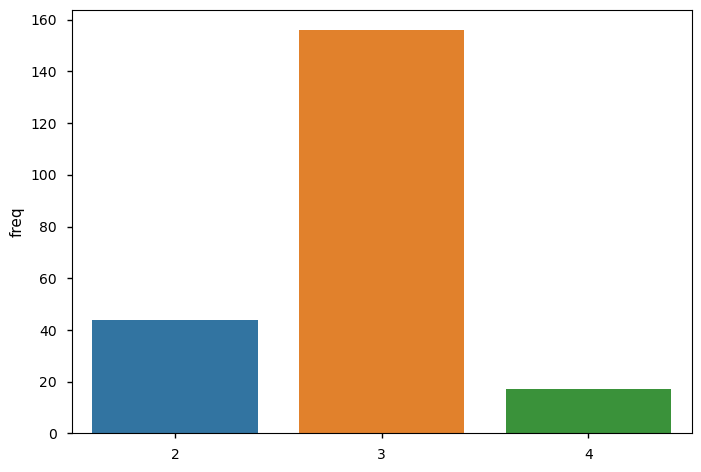

In [341]:
multiplicity, _, extreme_encoding = coincident_stats(df.vowel_free)

In [336]:
extreme_encoding

encoding_length
0       FLQ
1       FLA
2       BRQ
3       BLA
4       KLQ
       ... 
212    PRTQ
213     SKL
214     PLI
215     STI
216     KRT
Name: freq, Length: 217, dtype: object

In [337]:
multiplicity[multiplicity > 10]

encoding
FLQ     35
FLA     34
BRQ     33
BLA     32
KLQ     31
        ..
PRTQ    11
SKL     11
PLI     11
STI     11
KRT     11
Name: multiplicity, Length: 217, dtype: int64

In [342]:
df.to_csv('./dict_en.csv')

### Experiments

continue reducing the encoding length and the multiplicity (although sometimes we need to trade off between these two objectives)

In [343]:
df = pd.read_csv('./dict_en.csv', index_col=0, dtype={'sound':str,'freq':pd.Int64Dtype(),'encoding':str,'vowel_free':str}, na_filter=False)

In [345]:
df.loc['blackboard',['encoding','vowel_free']]

encoding      BLQKBQRD
vowel_free      BLKBRD
Name: blackboard, dtype: object

In [351]:
df.loc[df['encoding'].str.contains('Q[Y|W][Q]', regex=True)]

,sound,freq,encoding,vowel_free
word,,,,
actual,AE K CH AH W AH L,1788,QKCQWQL,QKCWL
afterward,AE F T ER W ER D,187,QFTQWQD,QFTWD
afterwards,AE F T ER W ER D Z,714,QFTQWQDS,QFTWDS
alleyway,AE L IY W EY,6,QLQWQ,QLWQ
alleyways,AE L IY W EY Z,<NA>,QLQWQA,QLWA
...,...,...,...,...
welterweight,W EH L T ER W EY T,0,WQLTQWQT,WLTWT
whippoorwills,W IH P ER W IH L Z,<NA>,WQPQWQLA,WPWLA
willowy,W IH L AH W IY,2,WQLQWQ,WLWQ


Further reductions:

This will be accounted for lazy/fuzzy pronounciation and be implemented by the users and not directly in the encoding.

For example we can reduce approximants whose property can be considered as an interpolation between a vowel and a consonant. Sometimes it's not easy to tell them from a continuous speech flow and usually omitted by lazy speakers.

There are several phonological circumstances for approximants in English:
`A` for approximant, `C` for consonant, `V` for vowel

1. At the beginning `A-V` (`A-C` is not possible)
2. At the end `-A`
3. `V-A-C`
4. `V-A-V`
5. `C-A-V`

- for semi-vowels `Y,W`, we identify the following circumstances as reducable: 2, 3, 4, 5
- for approximant `R,L`, we identify the following circumstances as reducable: 2, 3

and even more radical reduction: e.g. nasal elision
- for nasal `M,N,NG`: 2, 3(condition to certain trailing consonant)
